In [1]:
# !pip install yfinance PyPortfolioOpt bt

# 포트폴리오 백테스트
- 과거 데이터를 사용해 포트폴리오 전략의 성과를 검증하는 과정
- ex) "S&P500과 나스닥 50:50으로 투자했을 때 과거 10년간 수익률은 어땠을까?", "변동성을 낮추기 위해 국채 30%를 추가했을 때 결과는?"

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 'Malgun Gothic' 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 한글 깨짐 방지를 위한 마이너스 기호 설정
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import pandas as pd
import os

# [1] 데이터 불러오기
tickers = ['QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
data_path = './data_monthly'

df_list = []

for ticker in tickers:
    file_path = os.path.join(data_path, f'{ticker}_monthly.csv')
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = ticker
    df_list.append(df)

# [2] 하나의 데이터프레임으로 합치기 (Date, Ticker, Monthly Close)
df_all = pd.concat(df_list)
df_all = df_all[['Date', 'Ticker', 'Monthly Close']]

# [3] 피벗 테이블로 변환 (날짜 x 종목 형태)
pivot = df_all.pivot(index='Date', columns='Ticker', values='Monthly Close')

# [4] 특정 기간으로 자르기
start_date = '2012-01-31'  # SCHD 기준: 2011-10-31 이후 (첫 데이터는 2011-10-31, 그 이후는 2011-11-30, ...)
end_date = '2025-04-30'    # 원하는 종료일

pivot_trimmed = pivot.loc[start_date:end_date]

# [5] 결측치 확인 (필요시 dropna나 fillna 적용)
print("결측치 확인:")
print(pivot_trimmed.isna().sum())

# [6] 결과 저장 (원하는 경우)
pivot_trimmed.to_csv('merged_monthly_close.csv')

# [7] 결과 미리보기
print("\n✅ 최종 데이터:")
print(pivot_trimmed.head())

결측치 확인:
Ticker
GLD     0
QQQ     0
SCHD    0
SPY     0
TLT     0
dtype: int64

✅ 최종 데이터:
Ticker         GLD      QQQ    SCHD       SPY      TLT
Date                                                  
2012-01-31  169.31  53.7814  7.2145  103.4603  85.2020
2012-02-29  164.29  57.2288  7.4205  107.9510  82.9893
2012-03-31  162.12  60.1206  7.5615  111.4231  79.4739
2012-04-30  161.88  59.4175  7.5534  110.6793  83.3158
2012-05-31  151.62  55.2344  7.2660  104.0324  90.8354


In [4]:
# 포트폴리오 1 (안정형)
weights_1 = {'SPY': 0.2501, 'TLT': 0.2167, 'GLD': 0.2485, 'SCHD': 0.2847}

# 포트폴리오 2 (공격형)
weights_2 = {'SPY': 0.05, 'QQQ': 0.73, 'GLD': 0.02, 'SCHD': 0.2}

# 단일 포트폴리오
weights_3 = {'SPY': 1.0}
weights_4 = {'QQQ': 1.0}
weights_5 = {'TLT': 1.0}
weights_6 = {'GLD': 1.0}
weights_7 = {'SCHD': 1.0}

# 전체 리스트
all_tickers = list(set(weights_1.keys()) | set(weights_2.keys()) | set(weights_3.keys()) | set(weights_4.keys() | set(weights_5.keys() )))


안정형 Metrics:
  Total Return: 175.15%
  CAGR: 7.99%
  Max Drawdown: -19.34%

TLT Metrics:
  Total Return: 4.62%
  CAGR: 0.34%
  Max Drawdown: -47.61%

GLD Metrics:
  Total Return: 79.42%
  CAGR: 4.54%
  Max Drawdown: -40.97%

SCHD Metrics:
  Total Return: 257.89%
  CAGR: 10.17%
  Max Drawdown: -22.34%


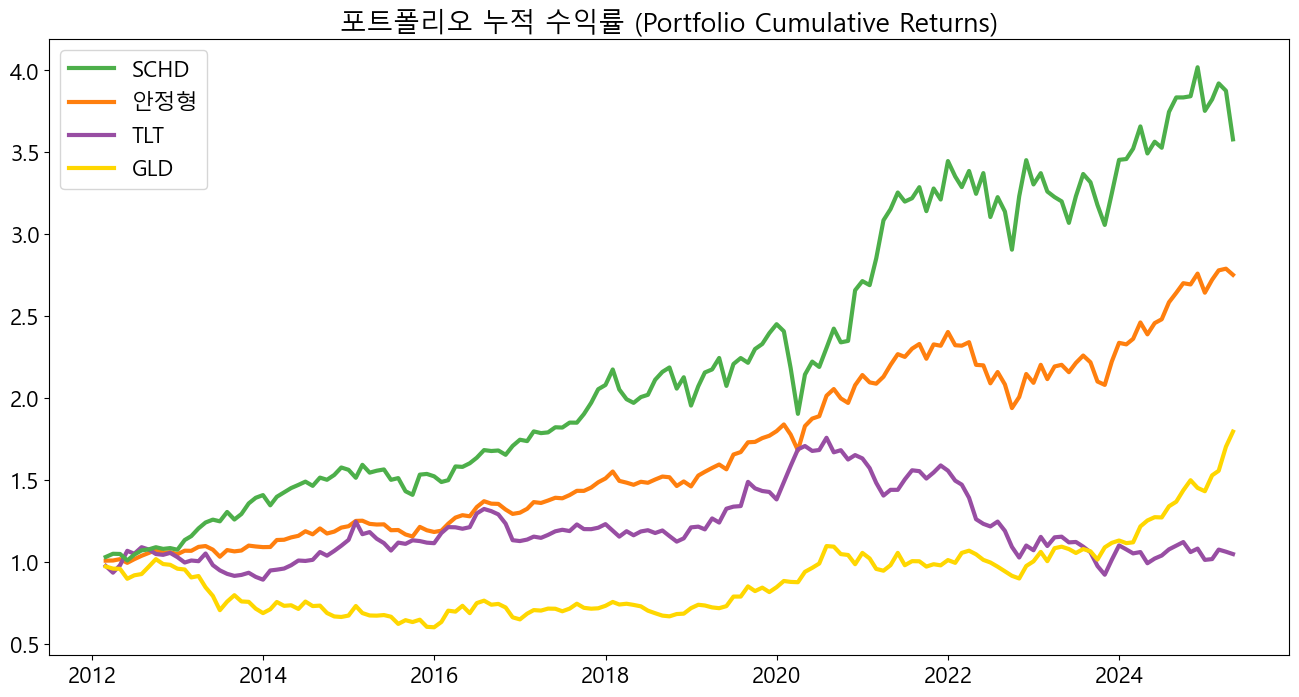

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (앞에서 만든 것)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    
    weights = pd.Series(weights_dict)
    
    portfolio_return = (returns * weights).sum(axis=1)
    cumulative_return = (1 + portfolio_return).cumprod()
    
    total_return = cumulative_return.iloc[-1] - 1
    n_years = (cumulative_return.index[-1] - cumulative_return.index[0]).days / 365.25
    CAGR = (cumulative_return.iloc[-1]) ** (1 / n_years) - 1
    MDD = ((cumulative_return / cumulative_return.cummax()) - 1).min()
    
    metrics = {
        'Total Return': f'{total_return:.2%}',
        'CAGR': f'{CAGR:.2%}',
        'Max Drawdown': f'{MDD:.2%}'
    }
    
    return cumulative_return, portfolio_return, metrics

# [4] 포트폴리오 테스트
portfolios = {
    '안정형': weights_1,
    'TLT': weights_5,
    'GLD': weights_6,
    'SCHD': weights_7
}

results = {}

for name, weights in portfolios.items():
    cum_ret, monthly_ret, metrics = backtest_portfolio(weights, monthly_returns)
    results[name] = {
        'Cumulative Return': cum_ret,
        'Monthly Return': monthly_ret,
        'Metrics': metrics
    }
    print(f'\n{name} Metrics:')
    for k, v in metrics.items():
        print(f'  {k}: {v}')

# [5] ETF별 대표 색상 정의
colors = {
    'TLT': '#984EA3',   # 보라
    'GLD': '#FFD700',   # 금색
    'SCHD': '#4DAF4A',  # 초록
    '안정형': '#FF7F0E'  # 진한 주황색
}

plt.rcParams.update({'font.size': 16})

# [6] 결과 시각화 (선에 표시되는 색상 적용)
plt.figure(figsize=(16,8))

lines = {}
for name, data in results.items():
    line, = plt.plot(data['Cumulative Return'], label=name, color=colors.get(name, '#000000'), linewidth=3)
    lines[name] = line

# 원하는 순서대로 범례 출력
order = ['SCHD', '안정형', 'TLT', 'GLD']
plt.legend([lines[name] for name in order], order)

plt.title('포트폴리오 누적 수익률 (Portfolio Cumulative Returns)')
plt.show()


공격형 Metrics:
  Total Return: 612.61%
  CAGR: 16.08%
  Max Drawdown: -28.39%

SPY Metrics:
  Total Return: 435.99%
  CAGR: 13.60%
  Max Drawdown: -23.93%

QQQ Metrics:
  Total Return: 784.08%
  CAGR: 18.00%
  Max Drawdown: -32.58%


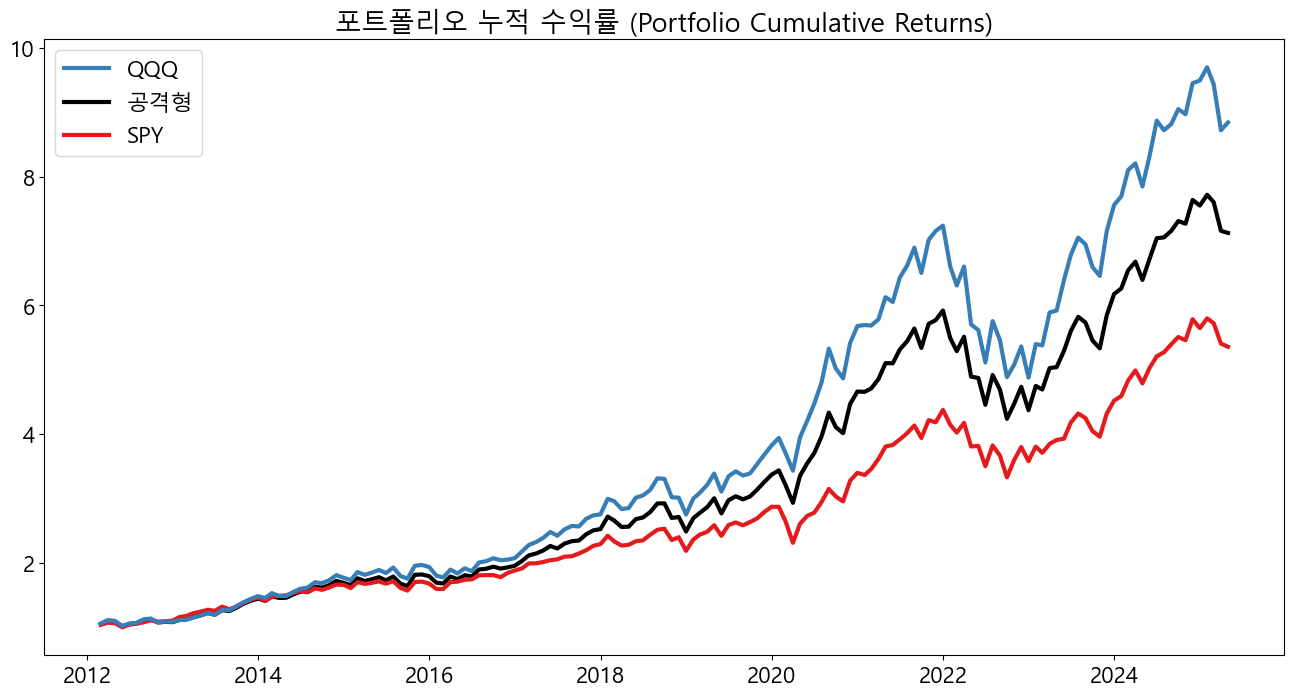

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (앞에서 만든 것)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    
    weights = pd.Series(weights_dict)
    
    portfolio_return = (returns * weights).sum(axis=1)
    cumulative_return = (1 + portfolio_return).cumprod()
    
    total_return = cumulative_return.iloc[-1] - 1
    n_years = (cumulative_return.index[-1] - cumulative_return.index[0]).days / 365.25
    CAGR = (cumulative_return.iloc[-1]) ** (1 / n_years) - 1
    MDD = ((cumulative_return / cumulative_return.cummax()) - 1).min()
    
    metrics = {
        'Total Return': f'{total_return:.2%}',
        'CAGR': f'{CAGR:.2%}',
        'Max Drawdown': f'{MDD:.2%}'
    }
    
    return cumulative_return, portfolio_return, metrics

# [4] 포트폴리오 테스트
portfolios = {
    '공격형': weights_2,
    'SPY': weights_3,
    'QQQ': weights_4,
}

results = {}

for name, weights in portfolios.items():
    cum_ret, monthly_ret, metrics = backtest_portfolio(weights, monthly_returns)
    results[name] = {
        'Cumulative Return': cum_ret,
        'Monthly Return': monthly_ret,
        'Metrics': metrics
    }
    print(f'\n{name} Metrics:')
    for k, v in metrics.items():
        print(f'  {k}: {v}')

# [5] ETF별 대표 색상 정의
colors = {
    'SPY': '#E41A1C',
    'QQQ': '#377EB8',
    'GLD': '#FFD700',
    'SCHD': '#4DAF4A',
    'TLT': '#984EA3',
    '안정형': '#FF7F0E',  # 진한 주황색 (눈에 잘 띄는 색)
    '공격형': '#000000'   # 검은색
}

plt.rcParams.update({'font.size': 16})

# [6] 결과 시각화 (선에 표시되는 색상 적용)
plt.figure(figsize=(16,8))

lines = {}
for name, data in results.items():
    line, = plt.plot(data['Cumulative Return'], label=name, color=colors.get(name, '#000000'), linewidth=3)
    lines[name] = line

# 범례 순서 지정 (QQQ, 공격형, SPY)
order = ['QQQ', '공격형', 'SPY']
plt.legend([lines[name] for name in order], order)

plt.title('포트폴리오 누적 수익률 (Portfolio Cumulative Returns)')
plt.show()

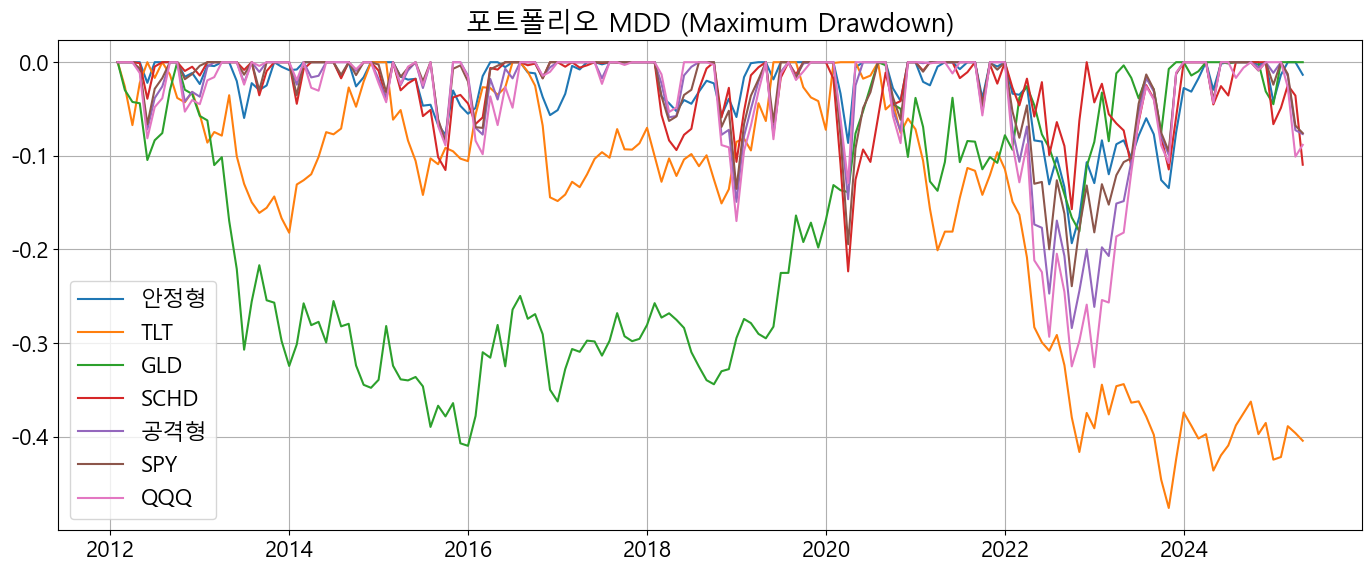

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 데이터 불러오기
tickers = ['QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
data_path = './data_monthly'  # 데이터 경로

df_list = []

for ticker in tickers:
    file_path = os.path.join(data_path, f'{ticker}_monthly.csv')
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = ticker
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all[['Date', 'Ticker', 'Monthly Close']]

# 피벗: 날짜 x 종목 형태
pivot = df_all.pivot(index='Date', columns='Ticker', values='Monthly Close')

# 특정 기간 잘라내기
start_date = '2012-01-31'
end_date = '2025-04-30'
pivot_trimmed = pivot.loc[start_date:end_date]

portfolios = {
    '안정형': weights_1,
    'TLT': weights_5,
    'GLD': weights_6,
    'SCHD': weights_7,
    '공격형': weights_2,
    'SPY': weights_3,
    'QQQ': weights_4,
}

# 3️⃣ 포트폴리오 누적 수익률 계산
portfolio_values = pd.DataFrame(index=pivot_trimmed.index)

for name, weights in portfolios.items():
    df = pivot_trimmed[list(weights.keys())].copy()
    df = df.pct_change().fillna(0)  # 월간 수익률 계산
    weighted_return = (df * pd.Series(weights)).sum(axis=1)
    cum_return = (1 + weighted_return).cumprod()
    portfolio_values[name] = cum_return

# 4️⃣ MDD 계산 함수
def calculate_mdd(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown

# MDD 계산
portfolio_mdd = pd.DataFrame(index=portfolio_values.index)

for name in portfolios.keys():
    portfolio_mdd[name] = calculate_mdd(portfolio_values[name])

# 5️⃣ MDD 그래프 그리기
plt.figure(figsize=(14, 6))
for name in portfolios.keys():
    plt.plot(portfolio_mdd.index, portfolio_mdd[name], label=name)
plt.title('포트폴리오 MDD (Maximum Drawdown)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

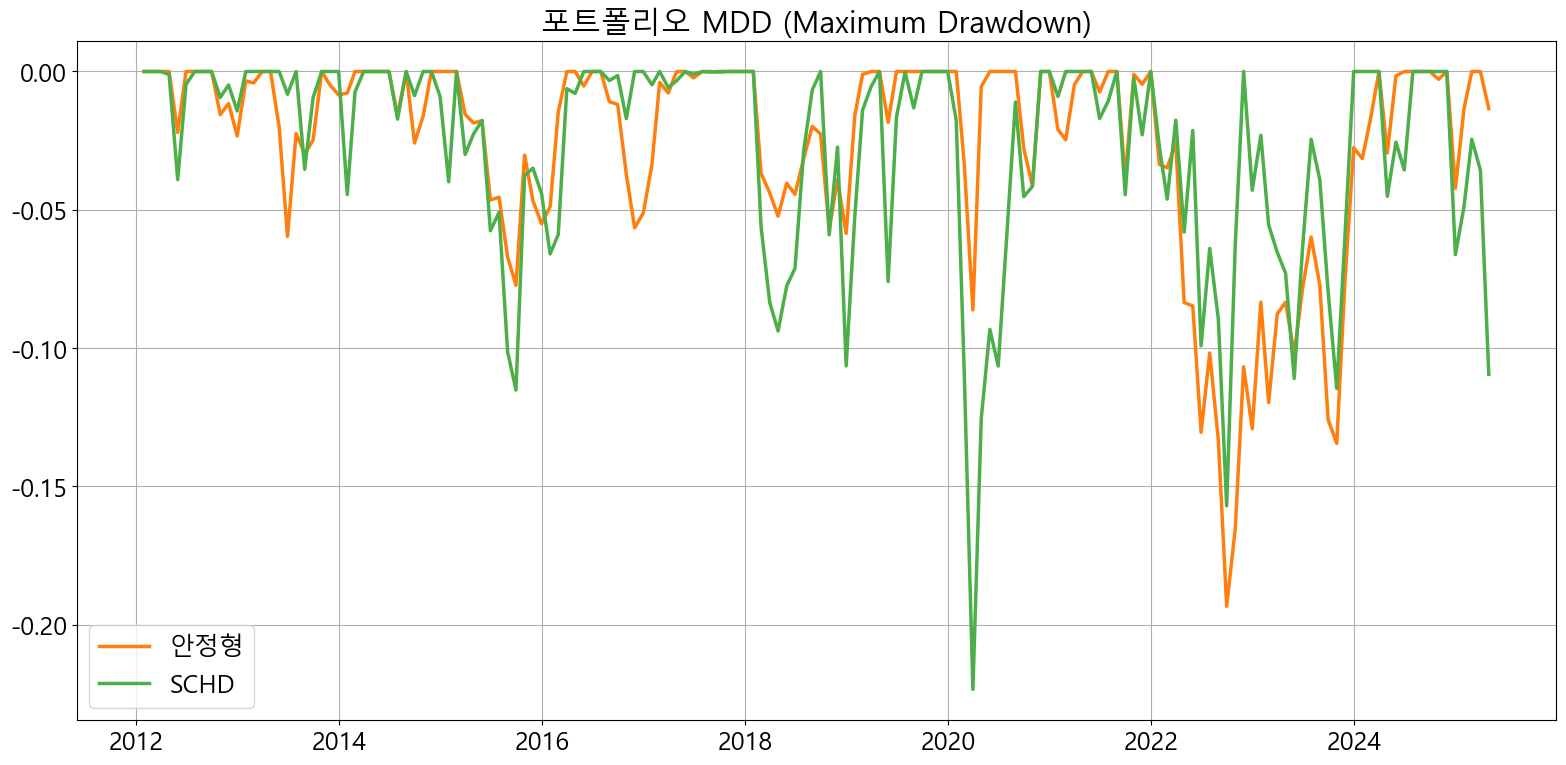

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# 색상 딕셔너리
colors = {
    'SPY': '#E41A1C', # 빨강
    'QQQ': '#377EB8', # 파랑
    'GLD': '#FFD700', # 노랑
    'SCHD': '#4DAF4A', # 초록
    'TLT': '#984EA3', # 보라
    '안정형': '#FF7F0E',  # 주황
    '공격형': '#000000' # 검정
}

# 1️⃣ 데이터 불러오기
tickers = ['QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
data_path = './data_monthly'  # 데이터 경로

df_list = []

for ticker in tickers:
    file_path = os.path.join(data_path, f'{ticker}_monthly.csv')
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = ticker
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all[['Date', 'Ticker', 'Monthly Close']]

# 피벗: 날짜 x 종목 형태
pivot = df_all.pivot(index='Date', columns='Ticker', values='Monthly Close')

# 특정 기간 잘라내기
start_date = '2012-01-31'
end_date = '2025-04-30'
pivot_trimmed = pivot.loc[start_date:end_date]

portfolios = {
    '안정형': weights_1,
    'SCHD': weights_7,
}

# 3️⃣ 포트폴리오 누적 수익률 계산
portfolio_values = pd.DataFrame(index=pivot_trimmed.index)

for name, weights in portfolios.items():
    df = pivot_trimmed[list(weights.keys())].copy()
    df = df.pct_change().fillna(0)  # 월간 수익률 계산
    weighted_return = (df * pd.Series(weights)).sum(axis=1)
    cum_return = (1 + weighted_return).cumprod()
    portfolio_values[name] = cum_return

# 4️⃣ MDD 계산 함수
def calculate_mdd(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown

# MDD 계산
portfolio_mdd = pd.DataFrame(index=portfolio_values.index)

for name in portfolios.keys():
    portfolio_mdd[name] = calculate_mdd(portfolio_values[name])

plt.rcParams.update({'font.size': 18})

# 5️⃣ MDD 그래프 그리기 (색상 지정)
plt.figure(figsize=(16, 8))
for name in portfolios.keys():
    plt.plot(portfolio_mdd.index, portfolio_mdd[name], label=name, color=colors.get(name, '#000000'), linewidth=2.5)
plt.title('포트폴리오 MDD (Maximum Drawdown)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

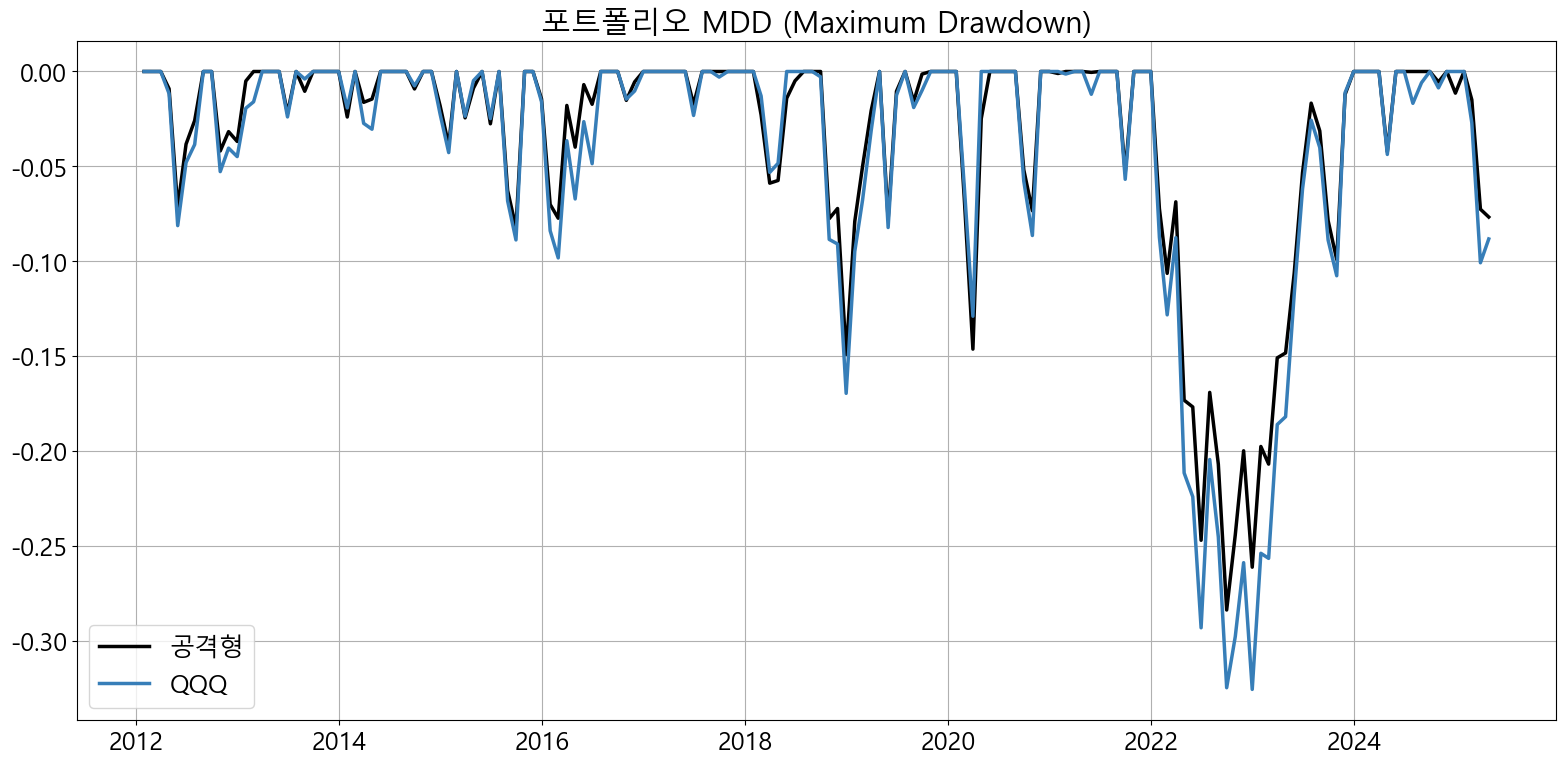

In [9]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# 색상 딕셔너리
colors = {
    'SPY': '#E41A1C', # 빨강
    'QQQ': '#377EB8', # 파랑
    'GLD': '#FFD700', # 노랑
    'SCHD': '#4DAF4A', # 초록
    'TLT': '#984EA3', # 보라
    '안정형': '#FF7F0E',  # 주황
    '공격형': '#000000' # 검정
}

# 1️⃣ 데이터 불러오기
tickers = ['QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
data_path = './data_monthly'  # 데이터 경로

df_list = []

for ticker in tickers:
    file_path = os.path.join(data_path, f'{ticker}_monthly.csv')
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = ticker
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all[['Date', 'Ticker', 'Monthly Close']]

# 피벗: 날짜 x 종목 형태
pivot = df_all.pivot(index='Date', columns='Ticker', values='Monthly Close')

# 특정 기간 잘라내기
start_date = '2012-01-31'
end_date = '2025-04-30'
pivot_trimmed = pivot.loc[start_date:end_date]

portfolios = {
    '공격형': weights_2,
    'QQQ': weights_4,
    # 'SPY': weights_3,
}

# 3️⃣ 포트폴리오 누적 수익률 계산
portfolio_values = pd.DataFrame(index=pivot_trimmed.index)

for name, weights in portfolios.items():
    df = pivot_trimmed[list(weights.keys())].copy()
    df = df.pct_change().fillna(0)  # 월간 수익률 계산
    weighted_return = (df * pd.Series(weights)).sum(axis=1)
    cum_return = (1 + weighted_return).cumprod()
    portfolio_values[name] = cum_return

# 4️⃣ MDD 계산 함수
def calculate_mdd(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown

# MDD 계산
portfolio_mdd = pd.DataFrame(index=portfolio_values.index)

for name in portfolios.keys():
    portfolio_mdd[name] = calculate_mdd(portfolio_values[name])

plt.rcParams.update({'font.size': 18})

# 5️⃣ MDD 그래프 그리기 (색상 지정)
plt.figure(figsize=(16, 8))
for name in portfolios.keys():
    plt.plot(portfolio_mdd.index, portfolio_mdd[name], label=name, color=colors.get(name, '#000000'), linewidth=2.5)
plt.title('포트폴리오 MDD (Maximum Drawdown)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

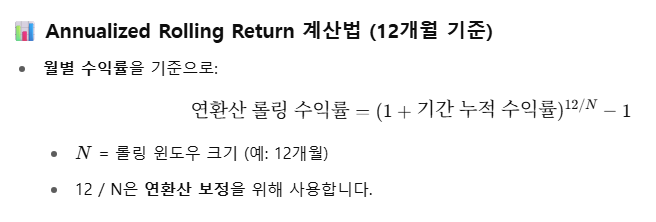

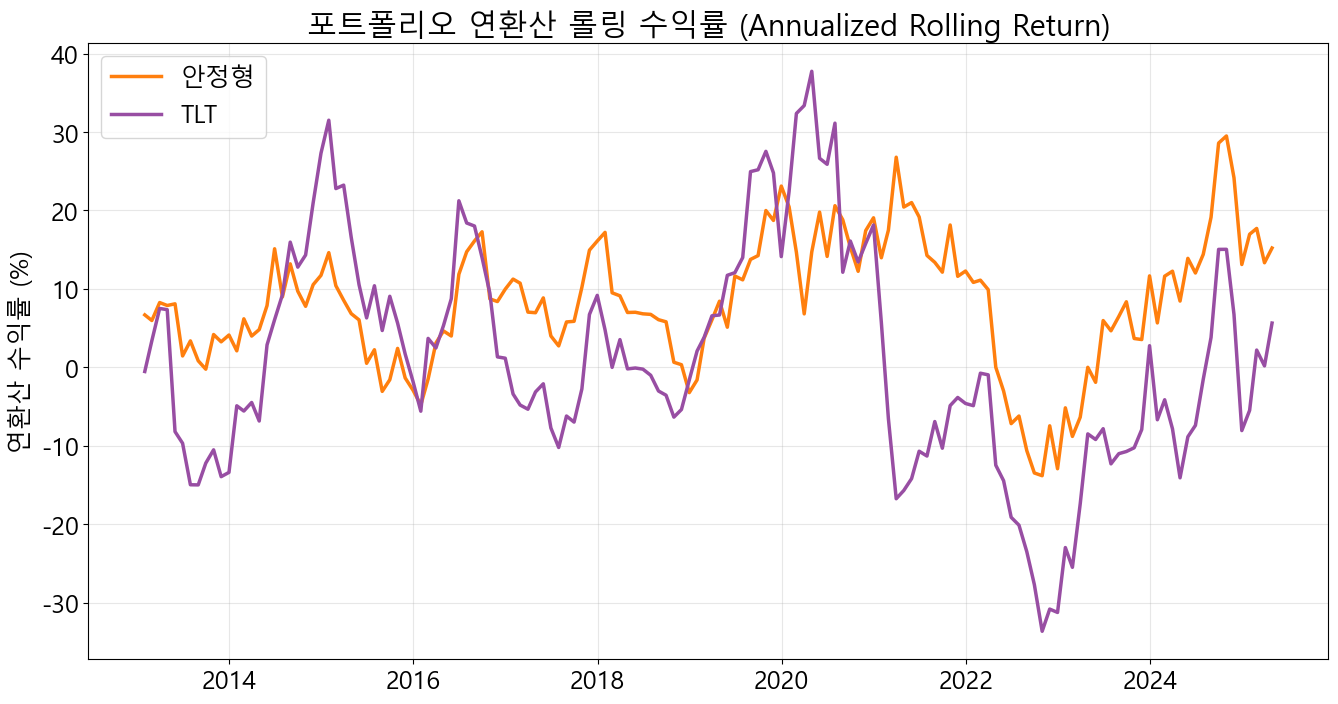

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (불러오기)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수 (누적수익률 관련 코드 포함되지만, 여기선 사용 X)
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '안정형': weights_1,
    'TLT': weights_5,
    # 'GLD': weights_6,
    # 'SCHD': weights_7
}

# [5] 색상 정의
colors = {
    'TLT': '#984EA3',   # 보라
    'GLD': '#FFD700',   # 금색
    'SCHD': '#4DAF4A',  # 초록
    '안정형': '#FF7F0E'  # 주황
}

# [6] Annualized Rolling Return 계산 및 시각화
rolling_window = 12  # 개월 기준

plt.figure(figsize=(16,8))

for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    
    # 누적곱의 12개월 롤링: (1 + r1) * (1 + r2) * ... * (1 + r12)
    rolling_return = (1 + monthly_ret).rolling(window=rolling_window).apply(np.prod, raw=True)
    
    # 연환산 보정: (rolling_return) ** (12/12) - 1 -> 일반적으로 12개월이므로 그대로 -1
    annualized_rolling_return = (rolling_return ** (12 / rolling_window) - 1) * 100
    
    plt.plot(annualized_rolling_return, label=name, color=colors.get(name, '#000000'), linewidth=2.5)

plt.legend()
plt.title('포트폴리오 연환산 롤링 수익률 (Annualized Rolling Return)')
plt.ylabel('연환산 수익률 (%)')
plt.grid(True, alpha=0.3)
plt.show()

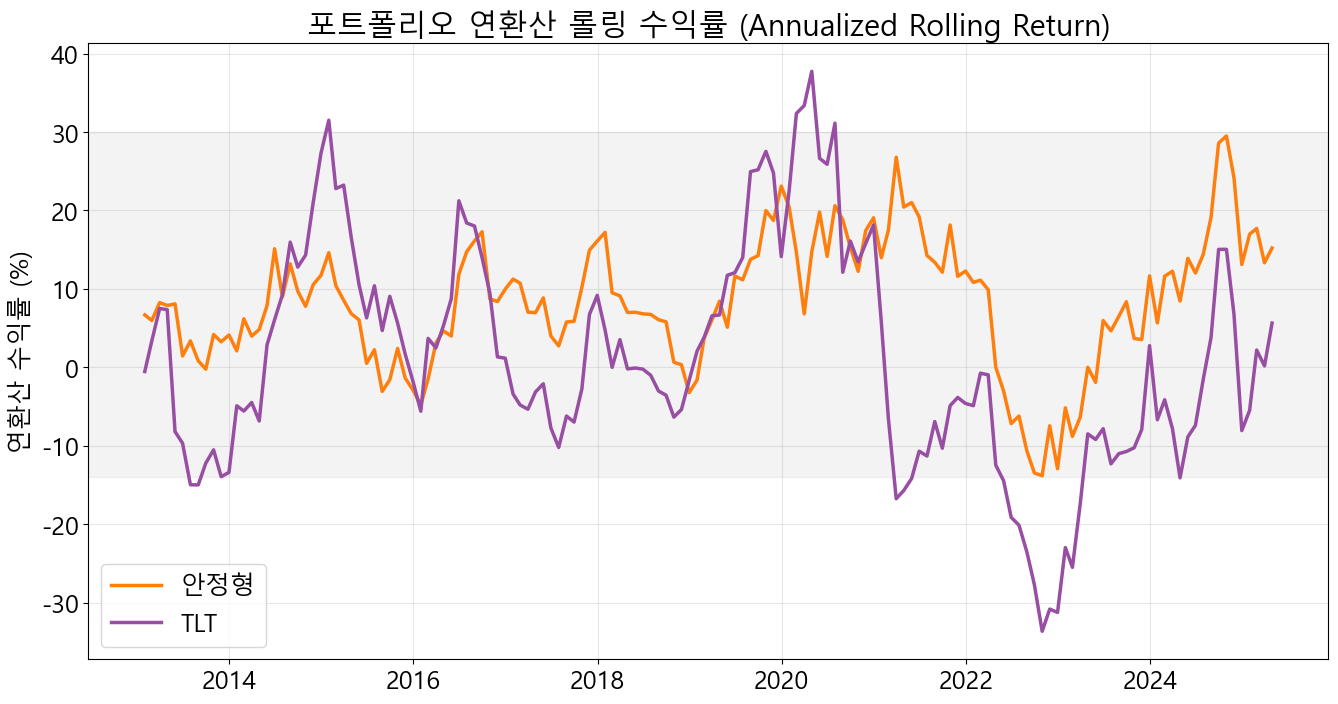

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (불러오기)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수 (누적수익률 관련 코드 포함되지만, 여기선 사용 X)
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '안정형': weights_1,
    'TLT': weights_5,
    # 'GLD': weights_6,
    # 'SCHD': weights_7
}

# [5] 색상 정의
colors = {
    'TLT': '#984EA3',   # 보라
    'GLD': '#FFD700',   # 금색
    'SCHD': '#4DAF4A',  # 초록
    '안정형': '#FF7F0E'  # 주황
}

# [6] Annualized Rolling Return 계산 및 시각화
rolling_window = 12  # 개월 기준

plt.figure(figsize=(16,8))

for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    
    # 누적곱의 12개월 롤링: (1 + r1) * (1 + r2) * ... * (1 + r12)
    rolling_return = (1 + monthly_ret).rolling(window=rolling_window).apply(np.prod, raw=True)
    
    # 연환산 보정: (rolling_return) ** (12/12) - 1 -> 일반적으로 12개월이므로 그대로 -1
    annualized_rolling_return = (rolling_return ** (12 / rolling_window) - 1) * 100
    
    plt.plot(annualized_rolling_return, label=name, color=colors.get(name, '#000000'), linewidth=2.5)

plt.legend()
plt.title('포트폴리오 연환산 롤링 수익률 (Annualized Rolling Return)')
plt.ylabel('연환산 수익률 (%)')

# y축 -14%부터 30%까지 회색 음영 추가 (alpha=0.2로 투명도 조절)
plt.axhspan(-14, 30, color='gray', alpha=0.09)

plt.grid(True, alpha=0.3)
plt.show()

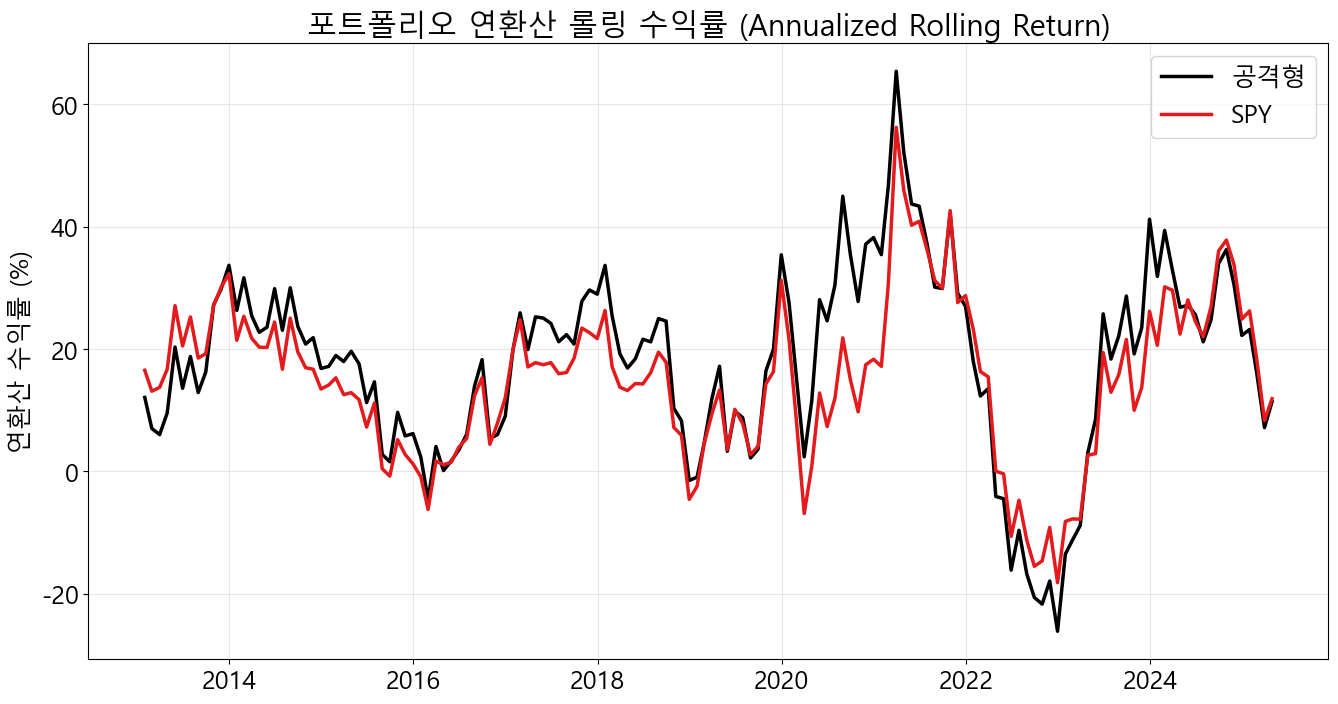

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (불러오기)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수 (누적수익률 관련 코드 포함되지만, 여기선 사용 X)
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '공격형': weights_2,
    'SPY': weights_3,
    # 'QQQ': weights_4,
}

# [5] 색상 정의
colors = {
    'SPY': '#E41A1C', # 빨강
    'QQQ': '#377EB8', # 파랑
    'GLD': '#FFD700', # 노랑
    'SCHD': '#4DAF4A', # 초록
    'TLT': '#984EA3', # 보라
    '안정형': '#FF7F0E',  # 주황
    '공격형': '#000000' # 검정
}

# [6] Annualized Rolling Return 계산 및 시각화
rolling_window = 12  # 개월 기준

plt.figure(figsize=(16,8))

for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    
    # 누적곱의 12개월 롤링: (1 + r1) * (1 + r2) * ... * (1 + r12)
    rolling_return = (1 + monthly_ret).rolling(window=rolling_window).apply(np.prod, raw=True)
    
    # 연환산 보정: (rolling_return) ** (12/12) - 1 -> 일반적으로 12개월이므로 그대로 -1
    annualized_rolling_return = (rolling_return ** (12 / rolling_window) - 1) * 100
    
    plt.plot(annualized_rolling_return, label=name, color=colors.get(name, '#000000'), linewidth=2.5)

plt.legend()
plt.title('포트폴리오 연환산 롤링 수익률 (Annualized Rolling Return)')
plt.ylabel('연환산 수익률 (%)')
plt.grid(True, alpha=0.3)
plt.show()

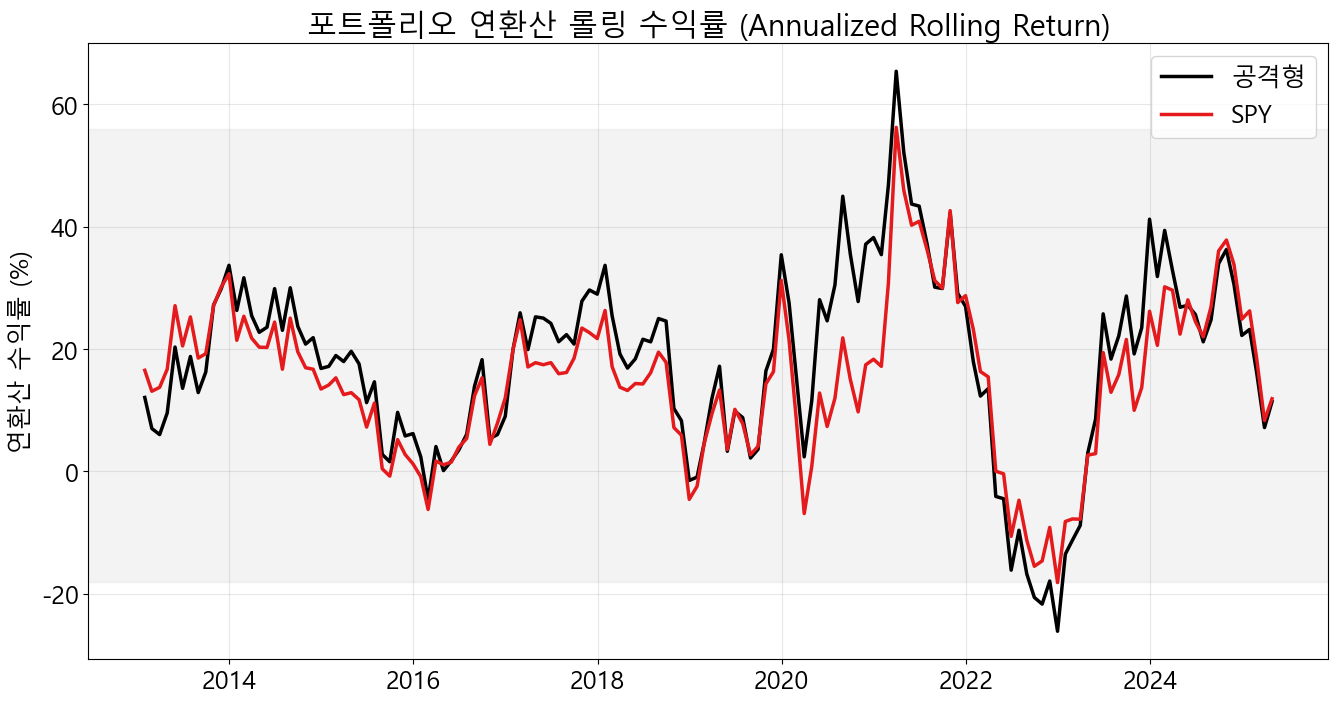

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [1] pivot_trimmed: 월별 종가 데이터 (불러오기)
# 예시: pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수 (누적수익률 관련 코드 포함되지만, 여기선 사용 X)
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '공격형': weights_2,
    'SPY': weights_3,
    # 'QQQ': weights_4,
}

# [5] 색상 정의
colors = {
    'SPY': '#E41A1C', # 빨강
    'QQQ': '#377EB8', # 파랑
    'GLD': '#FFD700', # 노랑
    'SCHD': '#4DAF4A', # 초록
    'TLT': '#984EA3', # 보라
    '안정형': '#FF7F0E',  # 주황
    '공격형': '#000000' # 검정
}

# [6] Annualized Rolling Return 계산 및 시각화
rolling_window = 12  # 개월 기준

plt.figure(figsize=(16,8))

for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    
    # 누적곱의 12개월 롤링: (1 + r1) * (1 + r2) * ... * (1 + r12)
    rolling_return = (1 + monthly_ret).rolling(window=rolling_window).apply(np.prod, raw=True)
    
    # 연환산 보정: (rolling_return) ** (12/12) - 1 -> 일반적으로 12개월이므로 그대로 -1
    annualized_rolling_return = (rolling_return ** (12 / rolling_window) - 1) * 100
    
    plt.plot(annualized_rolling_return, label=name, color=colors.get(name, '#000000'), linewidth=2.5)

plt.legend()
plt.title('포트폴리오 연환산 롤링 수익률 (Annualized Rolling Return)')
plt.ylabel('연환산 수익률 (%)')

# y축 -14%부터 30%까지 회색 음영 추가 (alpha=0.2로 투명도 조절)
plt.axhspan(-18, 56, color='gray', alpha=0.09)

plt.grid(True, alpha=0.3)
plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import colorsys

colors = {
    'SPY': '#E41A1C',     # 빨강
    'QQQ': '#377EB8',     # 파랑
    'GLD': '#FFD700',     # 노랑
    'SCHD': '#4DAF4A',    # 초록
    'TLT': '#984EA3',     # 보라
    '안정형': '#FF7F0E',   # 주황
    '공격형': '#000000'   # 검정
}

def pastel_color(hex_color, desat_factor=0.9, light_factor=1.3):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = r/255, g/255, b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    s *= desat_factor
    l = min(l * light_factor, 1.0)
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))

colors_pastel = {k: pastel_color(v) for k, v in colors.items()}

def plot_asset_allocation(weights_dict, title):
    labels = list(weights_dict.keys())
    sizes = list(weights_dict.values())
    assigned_colors = [colors_pastel.get(label, '#cccccc') for label in labels]

    plt.figure(figsize=(8,8))

    wedges, _ = plt.pie(
        sizes,
        labels=None,
        colors=assigned_colors,
        startangle=90,
        wedgeprops=dict(width=0.5, edgecolor='white')
    )

    for i, wedge in enumerate(wedges):
        ang = (wedge.theta2 + wedge.theta1) / 2.
        r_text = 0.73
        x_text = r_text * np.cos(np.deg2rad(ang))
        y_text = r_text * np.sin(np.deg2rad(ang))
        
        label = labels[i]
        pct_text = f"{sizes[i]*100:.1f}%"

        # '공격형'이면서 'GLD'인 경우 한 줄로 표시
        if title == '공격형' and label == 'GLD':
            combined_text = f"{label} {pct_text}"
            plt.text(
                x_text, y_text, combined_text,
                ha='center', va='center',
                fontsize=23, weight='semibold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )
        else:
            plt.text(
                x_text, y_text + 0.03, label,
                ha='center', va='bottom',
                fontsize=23, weight='semibold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )
            plt.text(
                x_text, y_text - 0.03, pct_text,
                ha='center', va='top',
                fontsize=20, weight='bold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )

    plt.title(title, fontsize=28, weight='semibold', pad=3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

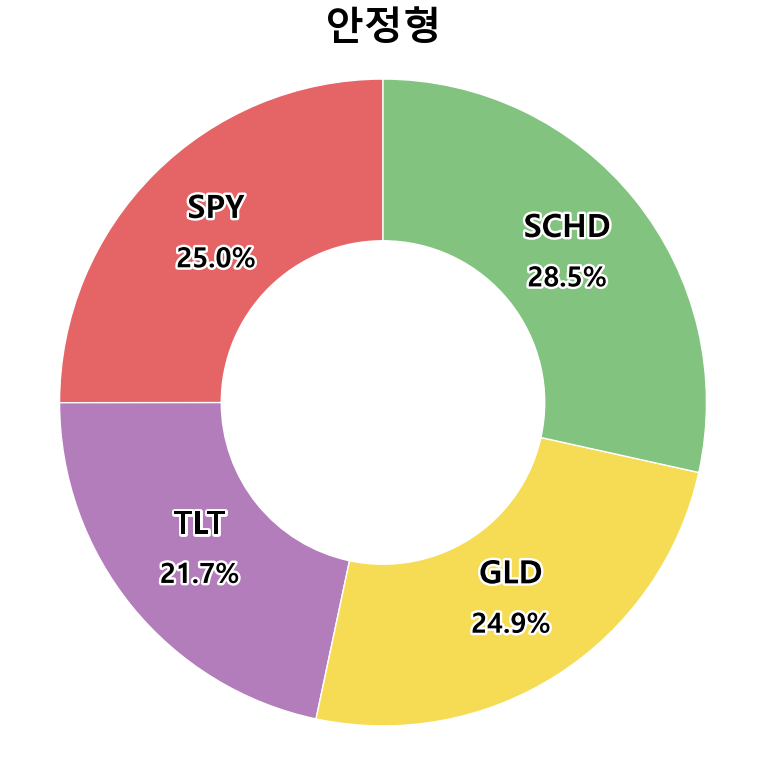

In [15]:
plot_asset_allocation(weights_1, '안정형')

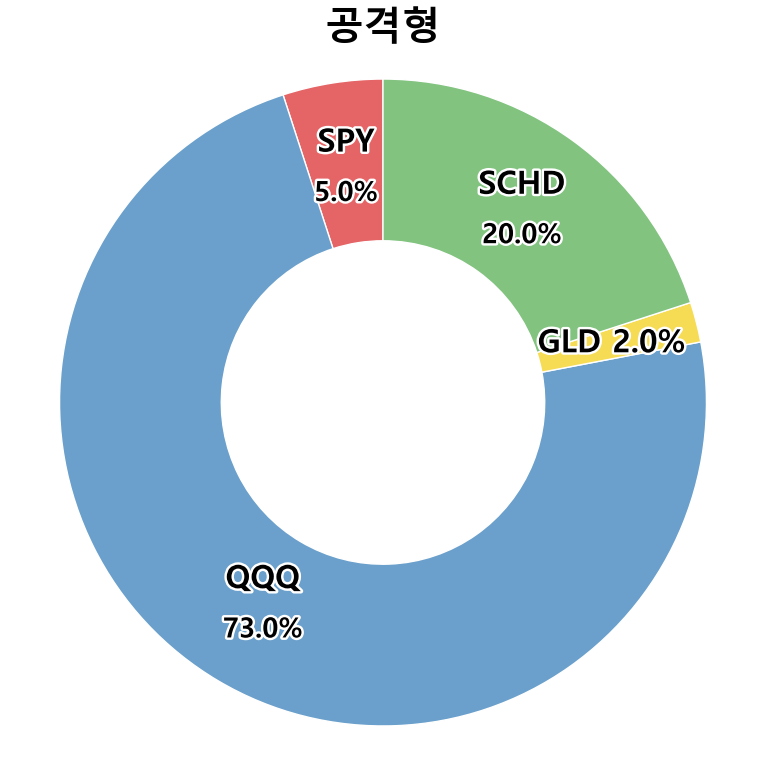

In [16]:
plot_asset_allocation(weights_2, '공격형')

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import colorsys

colors = {
    'SPY': '#E41A1C',     # 빨강
    'QQQ': '#377EB8',     # 파랑
    'GLD': '#FFD700',     # 노랑
    'SCHD': '#4DAF4A',    # 초록
    'TLT': '#984EA3',     # 보라
    '안정형': '#FF7F0E',   # 주황
    '공격형': '#000000'   # 검정
}

def pastel_color(hex_color, desat_factor=0.9, light_factor=1.3):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = r/255, g/255, b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    s *= desat_factor
    l = min(l * light_factor, 1.0)
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))

colors_pastel = {k: pastel_color(v) for k, v in colors.items()}

def plot_asset_allocation2(weights_dict, title):
    labels = list(weights_dict.keys())
    sizes = list(weights_dict.values())
    assigned_colors = [colors_pastel.get(label, '#cccccc') for label in labels]

    plt.figure(figsize=(8,8))

    wedges, _ = plt.pie(
        sizes,
        labels=None,
        colors=assigned_colors,
        startangle=90,
        wedgeprops=dict(width=0.5, edgecolor='white')
    )

    for i, wedge in enumerate(wedges):
        ang = (wedge.theta2 + wedge.theta1) / 2.
        r_text = 0.73
        x_text = r_text * np.cos(np.deg2rad(ang))
        y_text = r_text * np.sin(np.deg2rad(ang))
        
        label = labels[i]
        pct_text = f"{sizes[i]*100:.1f}%"

        # '공격형'이면서 'GLD'인 경우 한 줄로 표시
        if title == '공격형' and label == 'GLD':
            combined_text = f"{label} {pct_text}"
            plt.text(
                x_text, y_text, combined_text,
                ha='center', va='center',
                fontsize=35, weight='semibold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )
        else:
            plt.text(
                x_text, y_text + 0.03, label,
                ha='center', va='bottom',
                fontsize=35, weight='semibold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )
            plt.text(
                x_text, y_text - 0.03, pct_text,
                ha='center', va='top',
                fontsize=31, weight='bold', color='black',
                path_effects=[path_effects.withStroke(linewidth=3.5, foreground="white")]
            )

    plt.title(title, fontsize=35, weight='semibold', pad=3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

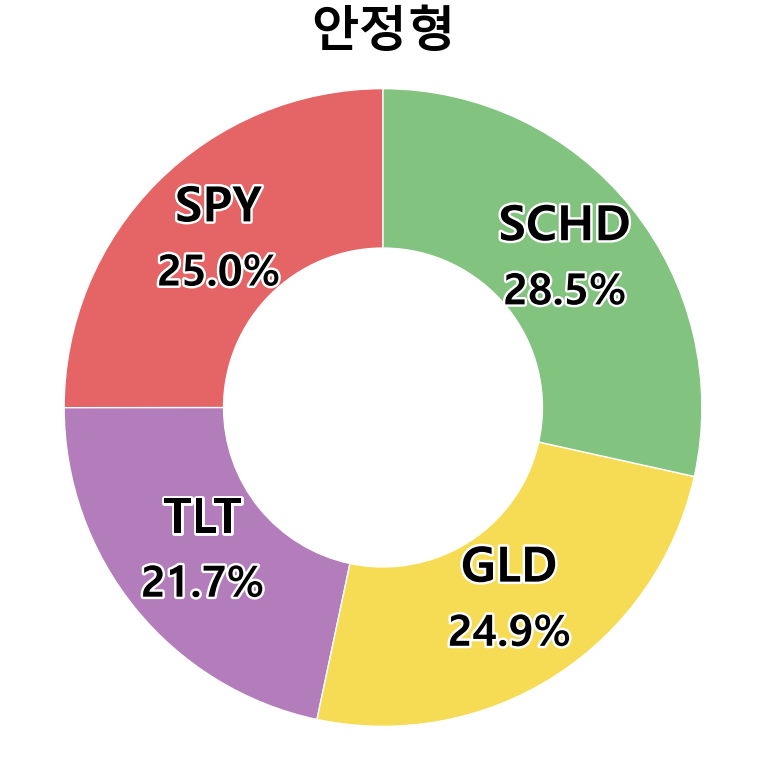

In [29]:
plot_asset_allocation2(weights_1, '안정형')

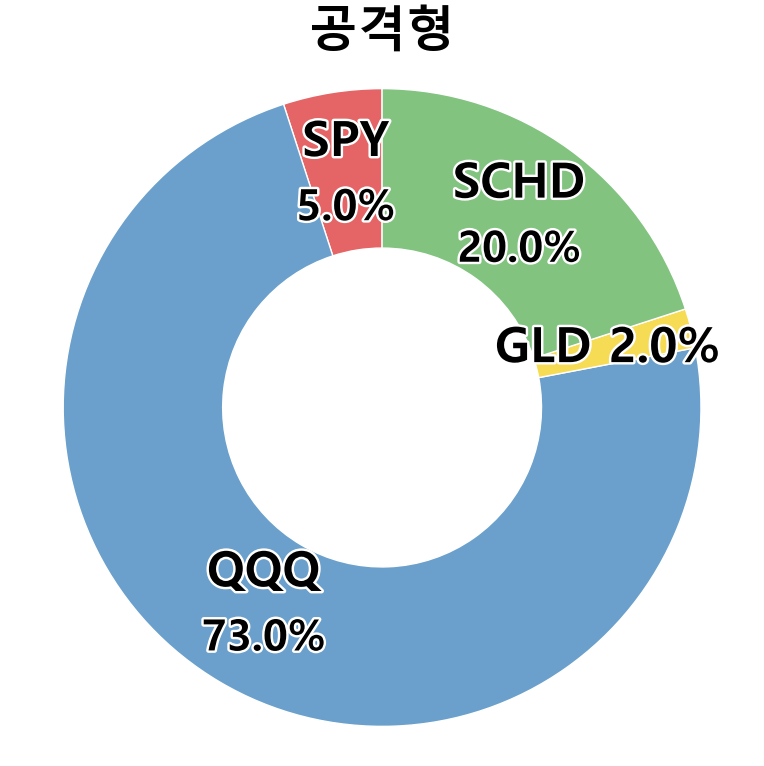

In [30]:
plot_asset_allocation2(weights_2, '공격형')

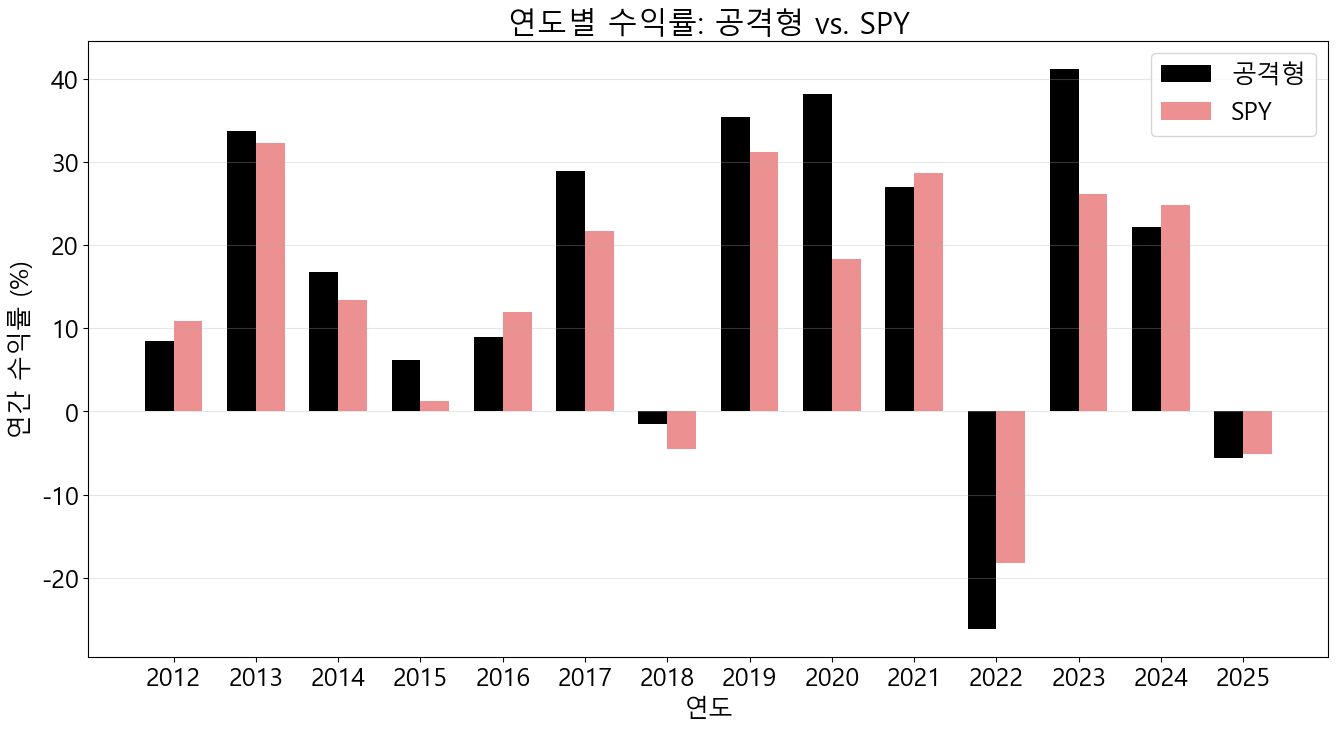

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys

# pastel_color 함수 정의
def pastel_color(hex_color, desat_factor=0.9, light_factor=1.5):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = r/255, g/255, b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    s *= desat_factor
    l = min(l * light_factor, 1.0)
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))

# [1] pivot_trimmed: 월별 종가 데이터 불러오기 예시
# pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '공격형': weights_2,
    'SPY': weights_3,
}

# [5] 원래 색상 정의
colors = {
    'SPY': '#E41A1C',   # 빨강
    '공격형': '#000000'  # 검정
}

# [6] pastel_color로 부드러운 색상으로 변환
pastel_colors = {k: pastel_color(v) for k, v in colors.items()}

# [7] 연도별 수익률 계산 함수
def yearly_return(monthly_ret):
    yearly_ret = (1 + monthly_ret).groupby(monthly_ret.index.year).prod() - 1
    return yearly_ret * 100

# [8] 연도별 수익률 계산
yearly_returns = {}
for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    yearly_returns[name] = yearly_return(monthly_ret)

years = yearly_returns['공격형'].index.intersection(yearly_returns['SPY'].index)

# [9] 막대그래프 그리기
bar_width = 0.35
x = np.arange(len(years))

fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x - bar_width/2, yearly_returns['공격형'].loc[years], width=bar_width, label='공격형', color=pastel_colors['공격형'])
ax.bar(x + bar_width/2, yearly_returns['SPY'].loc[years], width=bar_width, label='SPY', color=pastel_colors['SPY'])

ax.set_xlabel('연도')
ax.set_ylabel('연간 수익률 (%)')
ax.set_title('연도별 수익률: 공격형 vs. SPY')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.show()

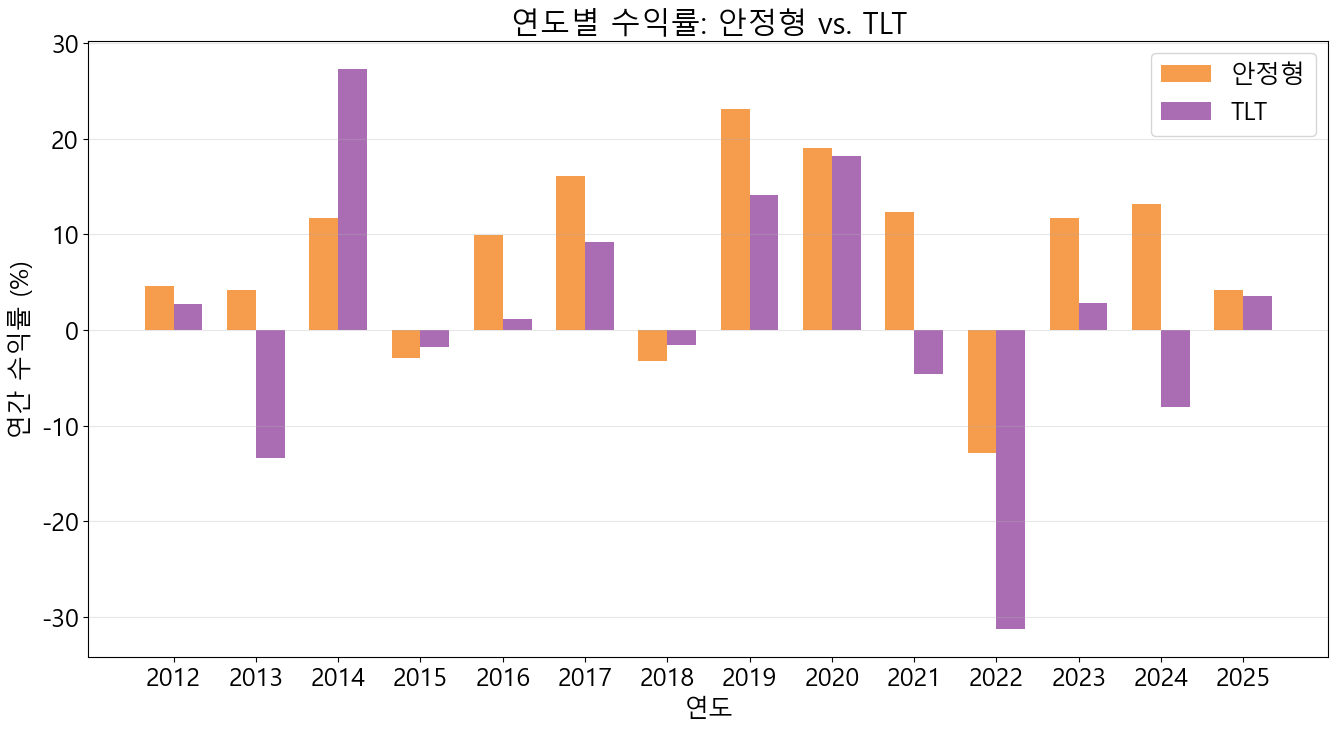

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys

# pastel_color 함수 정의
def pastel_color(hex_color, desat_factor=0.9, light_factor=1.2):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = r/255, g/255, b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    s *= desat_factor
    l = min(l * light_factor, 1.0)
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))

# [1] pivot_trimmed: 월별 종가 데이터 불러오기 예시
# pivot_trimmed = pd.read_csv('merged_monthly_close.csv', index_col=0, parse_dates=True)

# [2] 월별 수익률 계산
monthly_returns = pivot_trimmed.pct_change().dropna()

# [3] 포트폴리오 백테스트 함수
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)
    portfolio_return = (returns * weights).sum(axis=1)
    return portfolio_return

# [4] 포트폴리오 설정
portfolios = {
    '안정형': weights_1,
    'TLT': weights_5,
}

# [5] 원래 색상 정의
colors = {
    '안정형': '#FF7F0E',  # 주황
    'TLT': '#984EA3', # 보라
}

# [6] pastel_color로 부드러운 색상으로 변환
pastel_colors = {k: pastel_color(v) for k, v in colors.items()}

# [7] 연도별 수익률 계산 함수
def yearly_return(monthly_ret):
    yearly_ret = (1 + monthly_ret).groupby(monthly_ret.index.year).prod() - 1
    return yearly_ret * 100

# [8] 연도별 수익률 계산
yearly_returns = {}
for name, weights in portfolios.items():
    monthly_ret = backtest_portfolio(weights, monthly_returns)
    yearly_returns[name] = yearly_return(monthly_ret)

years = yearly_returns['안정형'].index.intersection(yearly_returns['TLT'].index)

# [9] 막대그래프 그리기
bar_width = 0.35
x = np.arange(len(years))

fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x - bar_width/2, yearly_returns['안정형'].loc[years], width=bar_width, label='안정형', color=pastel_colors['안정형'])
ax.bar(x + bar_width/2, yearly_returns['TLT'].loc[years], width=bar_width, label='TLT', color=pastel_colors['TLT'])

ax.set_xlabel('연도')
ax.set_ylabel('연간 수익률 (%)')
ax.set_title('연도별 수익률: 안정형 vs. TLT')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.show()

In [22]:
import pandas as pd
import numpy as np


# 포트폴리오별 가중치
weights_1 = {'SPY': 0.2501, 'TLT': 0.2167, 'GLD': 0.2485, 'SCHD': 0.2847}  # 안정형
weights_2 = {'SPY': 0.05, 'QQQ': 0.73, 'GLD': 0.02, 'SCHD': 0.2}          # 공격형


def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    total_weight = sum(weights_dict.values())
    if not np.isclose(total_weight, 1):
        print(f"Warning: 가중치 합이 1이 아닙니다. 합계={total_weight:.4f}")

    returns = monthly_returns[tickers]
    weights = pd.Series(weights_dict)

    # 월별 포트폴리오 수익률 계산
    portfolio_return = (returns * weights).sum(axis=1)
    cumulative_return = (1 + portfolio_return).cumprod()

    n_months = len(portfolio_return)
    n_years = n_months / 12

    total_return = cumulative_return.iloc[-1] - 1
    CAGR = cumulative_return.iloc[-1] ** (1 / n_years) - 1

    rolling_max = cumulative_return.cummax()
    drawdowns = (cumulative_return - rolling_max) / rolling_max
    MDD = drawdowns.min()

    mean_ret = portfolio_return.mean()
    std_ret = portfolio_return.std()
    sharpe = np.nan
    if std_ret != 0:
        sharpe = (mean_ret / std_ret) * np.sqrt(12)

    # ---- 추가: 수익 기여도 계산 ----
    # 각 종목 월별 수익률에 가중치 곱한 평균 (기여도)
    ret_contrib = (returns * weights).mean() / mean_ret if mean_ret != 0 else np.nan

    # ---- 추가: 위험 기여도 계산 ----
    cov_matrix = returns.cov()
    portfolio_var = weights.T @ cov_matrix @ weights
    portfolio_std = np.sqrt(portfolio_var)

    # 각 종목과 포트폴리오 공분산 벡터
    cov_with_portfolio = cov_matrix.dot(weights)
    risk_contrib = (weights * cov_with_portfolio) / portfolio_std / std_ret if std_ret != 0 else np.nan

    # risk_contrib 총합은 1이 되어야 함 (비율)
    risk_contrib = risk_contrib / risk_contrib.sum()

    metrics = {
        'Total Return': total_return,
        'CAGR': CAGR,
        'Max Drawdown': MDD,
        'Sharpe Ratio': sharpe,
        'Return Contribution': ret_contrib,
        'Risk Contribution': risk_contrib
    }

    return cumulative_return, portfolio_return, metrics


# 월별 수익률 계산 (pivot_trimmed는 Date x Ticker의 월별 종가 DataFrame)
monthly_returns = pivot_trimmed.pct_change().dropna()

portfolios = {
    '안정형': weights_1,
    '공격형': weights_2
}

results = {}

for name, weights in portfolios.items():
    cum_ret, monthly_ret, metrics = backtest_portfolio(weights, monthly_returns)
    results[name] = {
        'Cumulative Return': cum_ret,
        'Monthly Return': monthly_ret,
        'Metrics': metrics
    }

def print_portfolio_summary(name, weights, metrics):
    print(f"=== {name} 포트폴리오 요약 ===")
    print("구성 종목 및 비중:")
    for ticker, weight in weights.items():
        print(f"  {ticker}: {weight*100:.2f}%")
    print("\n주요 성과 지표:")
    print(f"  총 수익률: {metrics['Total Return']*100:.2f}%")
    print(f"  연평균 성장률 (CAGR): {metrics['CAGR']*100:.2f}%")
    print(f"  최대 낙폭 (MDD): {metrics['Max Drawdown']*100:.2f}%")
    print(f"  샤프 비율: {metrics['Sharpe Ratio']:.3f}")
    print("\n수익 기여도 (Return Contribution):")
    for ticker, val in metrics['Return Contribution'].items():
        print(f"  {ticker}: {val*100:.2f}%")
    print("\n위험 기여도 (Risk Contribution):")
    for ticker, val in metrics['Risk Contribution'].items():
        print(f"  {ticker}: {val*100:.2f}%")
    print("\n")

for name in portfolios.keys():
    print_portfolio_summary(name, portfolios[name], results[name]['Metrics'])

=== 안정형 포트폴리오 요약 ===
구성 종목 및 비중:
  SPY: 25.01%
  TLT: 21.67%
  GLD: 24.85%
  SCHD: 28.47%

주요 성과 지표:
  총 수익률: 175.15%
  연평균 성장률 (CAGR): 7.94%
  최대 낙폭 (MDD): -19.34%
  샤프 비율: 0.872

수익 기여도 (Return Contribution):
  SPY: 42.46%
  TLT: 3.31%
  GLD: 16.86%
  SCHD: 37.37%

위험 기여도 (Risk Contribution):
  SPY: 30.73%
  TLT: 14.44%
  GLD: 21.29%
  SCHD: 33.53%


=== 공격형 포트폴리오 요약 ===
구성 종목 및 비중:
  SPY: 5.00%
  QQQ: 73.00%
  GLD: 2.00%
  SCHD: 20.00%

주요 성과 지표:
  총 수익률: 612.61%
  연평균 성장률 (CAGR): 15.98%
  최대 낙폭 (MDD): -28.39%
  샤프 비율: 1.050

수익 기여도 (Return Contribution):
  SPY: 4.27%
  QQQ: 81.83%
  GLD: 0.68%
  SCHD: 13.21%

위험 기여도 (Risk Contribution):
  SPY: 4.42%
  QQQ: 80.93%
  GLD: 0.18%
  SCHD: 14.48%




In [23]:
def simulate_lump_sum_investment(portfolio_return, lump_sum_usd):
    """
    일시불 투자 계산
    :param portfolio_return: 포트폴리오 월별 수익률 (Series)
    :param lump_sum_usd: 최초 일시불 투자 금액 (달러)
    :return: 최종 투자 가치, 투자 원금, 투자 기간 (개월)
    """
    n_months = len(portfolio_return)
    
    portfolio_values = []
    portfolio_value = lump_sum_usd

    for month_idx in range(n_months):
        portfolio_value = portfolio_value * (1 + portfolio_return.iloc[month_idx])
        portfolio_values.append(portfolio_value)

    total_investment = lump_sum_usd
    final_value = portfolio_value
    duration_months = n_months

    return final_value, total_investment, duration_months, pd.Series(portfolio_values, index=portfolio_return.index)

# === 일시불 달러 투자 시뮬레이션 ===
lump_sum = 7312 # (25.05.25 환율 기준) 한국돈 약 1천만원

for name, result in results.items():
    monthly_ret = result['Monthly Return']
    final_value, total_investment, months, portfolio_values = simulate_lump_sum_investment(monthly_ret, lump_sum)

    print(f"=== {name} 포트폴리오 (일시불 투자) ===")
    print(f"투자 기간: {months}개월 ({months//12}년 {months%12}개월)")
    print(f"총 투자 원금: ${total_investment:,.2f}")
    print(f"최종 자산 가치: ${final_value:,.2f}")
    print(f"총 수익률: {((final_value / total_investment) - 1) * 100:.2f}%")
    print()

    # 필요시 포트폴리오 가치 시계열 출력
    # portfolio_values.plot(title=f"{name} 포트폴리오 가치 (일시불 투자)")

=== 안정형 포트폴리오 (일시불 투자) ===
투자 기간: 159개월 (13년 3개월)
총 투자 원금: $7,312.00
최종 자산 가치: $20,119.23
총 수익률: 175.15%

=== 공격형 포트폴리오 (일시불 투자) ===
투자 기간: 159개월 (13년 3개월)
총 투자 원금: $7,312.00
최종 자산 가치: $52,105.81
총 수익률: 612.61%



In [24]:
def simulate_dca_investment(portfolio_return, monthly_contribution_usd):
    """
    DCA 방식 적립식 투자 계산
    :param portfolio_return: 포트폴리오의 월별 수익률 (Series)
    :param monthly_contribution_usd: 매달 투자하는 금액 (예: 1000 달러)
    :return: 최종 투자 가치, 누적 투자 원금, 투자 기간 (개월)
    """
    n_months = len(portfolio_return)
    cumulative_investment = 0
    portfolio_value = 0

    portfolio_values = []

    for month_idx in range(n_months):
        # 이번 달 투자금
        cumulative_investment += monthly_contribution_usd
        # 이번 달 투자금 + 기존 자산에 수익률 적용
        portfolio_value = (portfolio_value + monthly_contribution_usd) * (1 + portfolio_return.iloc[month_idx])
        portfolio_values.append(portfolio_value)

    total_investment = cumulative_investment
    final_value = portfolio_value
    duration_months = n_months

    return final_value, total_investment, duration_months, pd.Series(portfolio_values, index=portfolio_return.index)


# 💰 매달 적립 투자한 달러 (25.05.25 환율 기준 약 63000원)
monthly_contribution = 46

for name, result in results.items():
    monthly_ret = result['Monthly Return']
    final_value, total_investment, months, portfolio_values = simulate_dca_investment(monthly_ret, monthly_contribution)

    print(f"=== {name} 포트폴리오 (적립식 투자) ===")
    print(f"투자 기간: {months}개월 ({months//12}년 {months%12}개월)")
    print(f"총 투자 원금: ${total_investment:,.2f}")
    print(f"최종 자산 가치: ${final_value:,.2f}")
    print(f"총 수익률: {((final_value / total_investment) - 1) * 100:.2f}%")
    print()

    # 필요시, 포트폴리오 가치 시계열 출력:
    # portfolio_values.plot(title=f"{name} 포트폴리오 가치 (적립식 투자)")

=== 안정형 포트폴리오 (적립식 투자) ===
투자 기간: 159개월 (13년 3개월)
총 투자 원금: $7,314.00
최종 자산 가치: $13,246.54
총 수익률: 81.11%

=== 공격형 포트폴리오 (적립식 투자) ===
투자 기간: 159개월 (13년 3개월)
총 투자 원금: $7,314.00
최종 자산 가치: $22,275.46
총 수익률: 204.56%



In [25]:
import pandas as pd
import numpy as np

# === 데이터 준비 ===
# 예시: pivot_trimmed는 월별 종가 데이터 (Date x Ticker DataFrame)
# monthly_returns = pivot_trimmed.pct_change().dropna()

# 포트폴리오별 가중치
weights_1 = {'SPY': 0.2501, 'TLT': 0.2167, 'GLD': 0.2485, 'SCHD': 0.2847}  # 안정형
weights_2 = {'SPY': 0.05, 'QQQ': 0.73, 'GLD': 0.02, 'SCHD': 0.2}          # 공격형

portfolios = {
    '안정형': weights_1,
    '공격형': weights_2
}

# === 포트폴리오 백테스트 ===
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    weights = pd.Series(weights_dict)

    returns = monthly_returns[tickers]
    portfolio_return = (returns * weights).sum(axis=1)

    cumulative_return = (1 + portfolio_return).cumprod()

    metrics = {
        'Monthly Return': portfolio_return,
        'Cumulative Return': cumulative_return
    }

    return metrics

results = {}
for name, weights in portfolios.items():
    results[name] = backtest_portfolio(weights, monthly_returns)

# === 적립식 투자(DCA) 시뮬레이션 함수 ===
def simulate_dca_investment(portfolio_return, monthly_contribution_usd, years):
    """
    DCA 방식 적립식 투자 계산
    :param portfolio_return: 포트폴리오의 월별 수익률 (Series)
    :param monthly_contribution_usd: 매달 투자하는 금액 (달러)
    :param years: 투자 기간 (년)
    :return: 최종 투자 가치, 누적 투자 원금, 기간(개월)
    """
    n_months = years * 12
    returns = portfolio_return.iloc[:n_months]

    cumulative_investment = 0
    portfolio_value = 0

    portfolio_values = []

    for month_idx in range(len(returns)):
        cumulative_investment += monthly_contribution_usd
        portfolio_value = (portfolio_value + monthly_contribution_usd) * (1 + returns.iloc[month_idx])
        portfolio_values.append(portfolio_value)

    total_investment = cumulative_investment
    final_value = portfolio_value

    return final_value, total_investment, n_months, pd.Series(portfolio_values, index=returns.index)

# === 투자 시뮬레이션 ===
years_list = [1, 3, 5, 10] # 1, 3, 5, 10년
monthly_contributions = [219.38, 365.63, 731.25] # 30, 50, 100만원

for name, result in results.items():
    print(f"\n=== {name} 포트폴리오 적립식 투자 결과 ===")
    for years in years_list:
        # 연환산 수익률 계산 (여기서 한 번만 출력)
        # DCA 수익률은 monthly_contribution와 무관하므로 대표값 하나로 계산
        sample_monthly_contribution = monthly_contributions[0]
        final_value_sample, total_investment_sample, months_sample, _ = simulate_dca_investment(
            result['Monthly Return'], sample_monthly_contribution, years)
        
        total_return_rate = (final_value_sample / total_investment_sample - 1) * 100
        cagr = ((final_value_sample / total_investment_sample) ** (1 / years) - 1) * 100

        print(f"투자기간: {years}년")
        print(f"  - 총 수익률: {total_return_rate:.2f}%")
        print(f"  - 연환산 수익률(CAGR): {cagr:.2f}%")
        
        # 매월 납입금 별로 원금, 최종자산가치만 출력
        for monthly_contribution in monthly_contributions:
            final_value, total_investment, months, _ = simulate_dca_investment(
                result['Monthly Return'], monthly_contribution, years)

            print(f"    매월 납입: ${monthly_contribution}")
            print(f"      - 총 투자 원금: ${total_investment:,.2f}")
            print(f"      - 최종 자산 가치: ${final_value:,.2f}")
        print()


=== 안정형 포트폴리오 적립식 투자 결과 ===
투자기간: 1년
  - 총 수익률: 3.70%
  - 연환산 수익률(CAGR): 3.70%
    매월 납입: $219.38
      - 총 투자 원금: $2,632.56
      - 최종 자산 가치: $2,729.95
    매월 납입: $365.63
      - 총 투자 원금: $4,387.56
      - 최종 자산 가치: $4,549.87
    매월 납입: $731.25
      - 총 투자 원금: $8,775.00
      - 최종 자산 가치: $9,099.62

투자기간: 3년
  - 총 수익률: 14.91%
  - 연환산 수익률(CAGR): 4.74%
    매월 납입: $219.38
      - 총 투자 원금: $7,897.68
      - 최종 자산 가치: $9,075.01
    매월 납입: $365.63
      - 총 투자 원금: $13,162.68
      - 최종 자산 가치: $15,124.88
    매월 납입: $731.25
      - 총 투자 원금: $26,325.00
      - 최종 자산 가치: $30,249.34

투자기간: 5년
  - 총 수익률: 15.40%
  - 연환산 수익률(CAGR): 2.91%
    매월 납입: $219.38
      - 총 투자 원금: $13,162.80
      - 최종 자산 가치: $15,189.88
    매월 납입: $365.63
      - 총 투자 원금: $21,937.80
      - 최종 자산 가치: $25,316.24
    매월 납입: $731.25
      - 총 투자 원금: $43,875.00
      - 최종 자산 가치: $50,631.78

투자기간: 10년
  - 총 수익률: 69.82%
  - 연환산 수익률(CAGR): 5.44%
    매월 납입: $219.38
      - 총 투자 원금: $26,325.60
      - 최종 자산 가치: $44,705.81
    매월 납

### 일괄적 환율 적용 (정확한 계산 대신, 발표용 이해 돕기 위해)
- 1 달러 = 1367 KRW (25.05.25 환율)
- (정확히 계산하려면 시기별 환율과 세금, 중간에 판매한 금액과 시점까지 고려 필요)

In [26]:
import pandas as pd
import numpy as np

# === 데이터 준비 ===
# 예시: pivot_trimmed는 월별 종가 데이터 (Date x Ticker DataFrame)
# monthly_returns = pivot_trimmed.pct_change().dropna()

# 포트폴리오별 가중치
weights_1 = {'SPY': 0.2501, 'TLT': 0.2167, 'GLD': 0.2485, 'SCHD': 0.2847}  # 안정형
weights_2 = {'SPY': 0.05, 'QQQ': 0.73, 'GLD': 0.02, 'SCHD': 0.2}          # 공격형

portfolios = {
    '안정형': weights_1,
    '공격형': weights_2
}

# === 포트폴리오 백테스트 ===
def backtest_portfolio(weights_dict, monthly_returns):
    tickers = list(weights_dict.keys())
    weights = pd.Series(weights_dict)

    returns = monthly_returns[tickers]
    portfolio_return = (returns * weights).sum(axis=1)

    cumulative_return = (1 + portfolio_return).cumprod()

    metrics = {
        'Monthly Return': portfolio_return,
        'Cumulative Return': cumulative_return
    }

    return metrics

results = {}
for name, weights in portfolios.items():
    results[name] = backtest_portfolio(weights, monthly_returns)

# === 적립식 투자(DCA) 시뮬레이션 함수 ===
def simulate_dca_investment(portfolio_return, monthly_contribution_usd, years):
    """
    DCA 방식 적립식 투자 계산
    :param portfolio_return: 포트폴리오의 월별 수익률 (Series)
    :param monthly_contribution_usd: 매달 투자하는 금액 (달러)
    :param years: 투자 기간 (년)
    :return: 최종 투자 가치, 누적 투자 원금, 기간(개월)
    """
    n_months = years * 12
    returns = portfolio_return.iloc[:n_months]

    cumulative_investment = 0
    portfolio_value = 0

    portfolio_values = []

    for month_idx in range(len(returns)):
        cumulative_investment += monthly_contribution_usd
        portfolio_value = (portfolio_value + monthly_contribution_usd) * (1 + returns.iloc[month_idx])
        portfolio_values.append(portfolio_value)

    total_investment = cumulative_investment
    final_value = portfolio_value

    return final_value, total_investment, n_months, pd.Series(portfolio_values, index=returns.index)

# === 투자 시뮬레이션 ===
years_list = [1, 3, 5, 10] # 1, 3, 5, 10년
monthly_contributions = [219.38, 365.63, 731.25] # 30, 50, 100만원

exchange_rate = 1367.53  # 25.05.25 환율

for name, result in results.items():
    print(f"\n=== {name} 포트폴리오 적립식 투자 결과 ===")
    for years in years_list:
        sample_monthly_contribution = monthly_contributions[0]
        final_value_sample, total_investment_sample, months_sample, _ = simulate_dca_investment(
            result['Monthly Return'], sample_monthly_contribution, years)
        
        total_return_rate = (final_value_sample / total_investment_sample - 1) * 100
        cagr = ((final_value_sample / total_investment_sample) ** (1 / years) - 1) * 100

        print(f"투자기간: {years}년")
        print(f"  - 총 수익률: {total_return_rate:.2f}%")
        print(f"  - 연환산 수익률(CAGR): {cagr:.2f}%")
        
        for monthly_contribution in monthly_contributions:
            final_value, total_investment, months, _ = simulate_dca_investment(
                result['Monthly Return'], monthly_contribution, years)

            print(f"    매월 납입: ${monthly_contribution} (${monthly_contribution * exchange_rate:,.0f} KRW)")
            print(f"      - 총 투자 원금: ${total_investment:,.2f} ({total_investment * exchange_rate:,.0f} KRW)")
            print(f"      - 최종 자산 가치: ${final_value:,.2f} ({final_value * exchange_rate:,.0f} KRW)")
        print()


=== 안정형 포트폴리오 적립식 투자 결과 ===
투자기간: 1년
  - 총 수익률: 3.70%
  - 연환산 수익률(CAGR): 3.70%
    매월 납입: $219.38 ($300,009 KRW)
      - 총 투자 원금: $2,632.56 (3,600,105 KRW)
      - 최종 자산 가치: $2,729.95 (3,733,288 KRW)
    매월 납입: $365.63 ($500,010 KRW)
      - 총 투자 원금: $4,387.56 (6,000,120 KRW)
      - 최종 자산 가치: $4,549.87 (6,222,089 KRW)
    매월 납입: $731.25 ($1,000,006 KRW)
      - 총 투자 원금: $8,775.00 (12,000,076 KRW)
      - 최종 자산 가치: $9,099.62 (12,444,009 KRW)

투자기간: 3년
  - 총 수익률: 14.91%
  - 연환산 수익률(CAGR): 4.74%
    매월 납입: $219.38 ($300,009 KRW)
      - 총 투자 원금: $7,897.68 (10,800,314 KRW)
      - 최종 자산 가치: $9,075.01 (12,410,348 KRW)
    매월 납입: $365.63 ($500,010 KRW)
      - 총 투자 원금: $13,162.68 (18,000,360 KRW)
      - 최종 자산 가치: $15,124.88 (20,683,724 KRW)
    매월 납입: $731.25 ($1,000,006 KRW)
      - 총 투자 원금: $26,325.00 (36,000,227 KRW)
      - 최종 자산 가치: $30,249.34 (41,366,883 KRW)

투자기간: 5년
  - 총 수익률: 15.40%
  - 연환산 수익률(CAGR): 2.91%
    매월 납입: $219.38 ($300,009 KRW)
      - 총 투자 원금: $13,162.80 (18,000,52

In [27]:
def calculate_asset_performance(monthly_prices):
    monthly_returns = monthly_prices.pct_change().dropna()
    annual_returns = monthly_returns.resample('YE').apply(lambda x: (1 + x).prod() - 1)

    results = {}

    for ticker in monthly_prices.columns:
        ret = monthly_returns[ticker]
        ann_ret = annual_returns[ticker]

        # CAGR 계산
        n_years = (monthly_prices.index[-1] - monthly_prices.index[0]).days / 365.25
        total_return = (monthly_prices[ticker].iloc[-1] / monthly_prices[ticker].iloc[0]) - 1
        CAGR = (1 + total_return) ** (1 / n_years) - 1

        # 연 환산 표준편차 (Stdev)
        Stdev = ret.std() * np.sqrt(12)

        # 최고/최악 연간 수익률
        Best_Year = ann_ret.max()
        Worst_Year = ann_ret.min()

        # 최대 낙폭 계산
        cumulative = (1 + ret).cumprod()
        rolling_max = cumulative.cummax()
        drawdowns = (cumulative - rolling_max) / rolling_max
        Max_Drawdown = drawdowns.min()

        # 샤프 비율 (무위험 수익률 0% 가정)
        Sharpe = ret.mean() / ret.std() * np.sqrt(12) if ret.std() != 0 else np.nan

        # 소르티노 비율 (하방변동성만 사용)
        negative_returns = ret[ret < 0]
        Downside_std = negative_returns.std() * np.sqrt(12) if not negative_returns.empty else np.nan
        Sortino = ret.mean() / Downside_std if Downside_std and Downside_std != 0 else np.nan

        results[ticker] = {
            'CAGR': CAGR,
            'Stdev': Stdev,
            'Best Year': Best_Year,
            'Worst Year': Worst_Year,
            'Max Drawdown': Max_Drawdown,
            'Sharpe Ratio': Sharpe,
            'Sortino Ratio': Sortino
        }

    return pd.DataFrame(results).T

# 사용법 예시
performance_df = calculate_asset_performance(pivot_trimmed)
print(performance_df)

          CAGR     Stdev  Best Year  Worst Year  Max Drawdown  Sharpe Ratio  \
GLD   0.045119  0.147235   0.266569   -0.283298     -0.409739      0.372708   
QQQ   0.178844  0.171587   0.548556   -0.325770     -0.325770      1.050255   
SCHD  0.101047  0.138831   0.311306   -0.060486     -0.223412      0.764862   
SPY   0.135138  0.141239   0.323078   -0.181753     -0.239272      0.972303   
TLT   0.003419  0.134620   0.273019   -0.312345     -0.476136      0.091778   

      Sortino Ratio  
GLD        0.057773  
QQQ        0.136239  
SCHD       0.094897  
SPY        0.117455  
TLT        0.013875  
